## Описание проекта

Необходимо подготовить исследование рынка общественного питания Москвы для открытия нового бизнеса на основе открытых данные о заведениях общественного питания в Москве.

## Шаг №1. Загрузите данные и подготовьте их к анализу
Загрузите данные о заведениях общественного питания Москвы. Убедитесь, что тип данных в каждой колонке — правильный, а также отсутствуют пропущенные значения и дубликаты. При необходимости обработайте их.

In [1]:
import pandas as pd
import numpy as np
import math as mth
import matplotlib.pyplot as plt
import scipy.stats as stats
import seaborn as sns
import re
from io import BytesIO
import requests

pd.options.display.float_format = '{:.2f}'.format
plt.style.use('seaborn-deep')

In [2]:
pip install -U seaborn

Defaulting to user installation because normal site-packages is not writeable
Requirement already up-to-date: seaborn in /home/jovyan/.local/lib/python3.7/site-packages (0.11.1)
Note: you may need to restart the kernel to use updated packages.


In [3]:
try: 
    df = pd.read_csv('rest_data.csv') # 

except FileNotFoundError:
    df = pd.read_csv('/datasets/rest_data.csv' ) #яндексовский путь

In [4]:
df.info()#вывод общей информации
display(df.sample(5, random_state=1)) # вывод 10 рандомных строк
print(df.isna().mean()) # вывод среднего количества пропущенных значений
print('duplicates:', df.duplicated().sum()) # вывод количества дубликатов

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15366 entries, 0 to 15365
Data columns (total 6 columns):
id             15366 non-null int64
object_name    15366 non-null object
chain          15366 non-null object
object_type    15366 non-null object
address        15366 non-null object
number         15366 non-null int64
dtypes: int64(2), object(4)
memory usage: 720.4+ KB


,id,object_name,chain,object_type,address,number
2973,22736,Луна,нет,кафе,"город Москва, Михалковская улица, дом 38, стро...",40
2593,29065,Столовая ГБОУ 45 Гимназия имени Л.И. Мильграмма,нет,столовая,"город Москва, улица Гримау, дом 8",300
6737,23349,Столовая ГБОУ СОШ № 1900,нет,столовая,"город Москва, Дубравная улица, дом 41, корпус 4",240
14940,222539,Holy Vegan,нет,кафе,"город Москва, Ходынский бульвар, дом 4",0
4088,26585,Ресторан «Очаг гурманов»,нет,ресторан,"город Москва, Каширское шоссе, дом 51, корпус 3",42


id            0.00
object_name   0.00
chain         0.00
object_type   0.00
address       0.00
number        0.00
dtype: float64
duplicates: 0


В датасете нет пропущенных значений, простых дупликатов не обнаружено, однако мы можем зафиксировать проблему написания торговых точек. Проверим, нет ли похожих написаний в колонках с типом заведения, вопросом о сетевое ли заведение и названиями кафе.

In [5]:
df['chain'].unique()

array(['нет', 'да'], dtype=object)

заменим ответы да нет на 0 и 1, превратив тип данных в целочисленный для экономии памяти.

In [6]:
df.loc[df['chain'] == 'да', 'chain'] = 1 # заменим 'да' на 1
df.loc[df['chain'] == 'нет', 'chain'] = 0 # заменим 'нет' на 0
df['chain']=df['chain'].astype('int')

In [7]:
df['object_type'].unique()

array(['кафе', 'столовая', 'закусочная',
       'предприятие быстрого обслуживания', 'ресторан', 'кафетерий',
       'буфет', 'бар', 'магазин (отдел кулинарии)'], dtype=object)

Взглянем на названия сетевых заведений (несетевые единичны и их написание не повлияет на анализ), чтобы проверить, если ли дубликаты из-за разного написания. 

In [8]:
df['object_type'] = df['object_type'].str.replace('предприятие быстрого обслуживания','фастфуд')

In [9]:
df.loc[df['object_type'] == "магазин (отдел кулинарии)","object_type" ] = 'кулинария'

In [10]:
df[df['chain']==1]['object_name'].value_counts().head(10)

KFC                155
Шоколадница        141
Макдоналдс         122
Бургер Кинг        122
Домино'с Пицца      86
Теремок             84
Крошка Картошка     82
Милти               65
Суши Wok            61
Папа Джонс          50
Name: object_name, dtype: int64

Устраним обнаруженные проблемы через приведение к единому регистру и замену, так как это наиболее быстро.

In [11]:
df['object_name']=df['object_name'].str.lower()

In [12]:
df['object_name'] = df['object_name'].str.replace('«','')
df['object_name'] = df['object_name'].str.replace('»','')
df['object_name'] = df['object_name'].str.replace('кофейня ','')
df['object_name'] = df['object_name'].str.replace('кафе ','')
df['object_name'] = df['object_name'].str.replace('ресторан ','')
df['object_name'] = df['object_name'].str.replace(' шоколадница','шоколадница')
df['object_name'] = df['object_name'].str.replace('старбакс','starbucks')
df['object_name'] = df['object_name'].str.replace('пиццерия папа джонс','папа джонс')
df['object_name'] = df['object_name'].str.replace('ростикс kfc', 'kfc')
df['object_name'] = df['object_name'].str.replace('сабвей','subway')

In [13]:
df.duplicated().sum()

0

In [14]:
df[df['chain']==1]['object_name'].value_counts().head(20)

шоколадница        183
kfc                178
макдоналдс         165
бургер кинг        144
теремок            105
домино'с пицца      92
крошка картошка     92
суши wok            74
милти               72
папа джонс          65
starbucks           59
subway              56
чайхона №1          49
додо пицца          49
якитория            48
тануки              47
кофе с собой        46
хинкальная          43
кофе хаус           38
хлеб насущный       33
Name: object_name, dtype: int64

**Вывод**

Мы ознакомились с данными. Типы данных корректы, однако мы заменили дихотомический признак сетевое или не сетвое заведение на целочисленный тип данных (где 1 - сетевое, 0- несетевое). Пропусков и явных дубликатов не было обнаружено.
Оданако, мы заметили разные варианты написания одного и того же сетевого заведения в некоторых случаях. В случаях с многочисленными повторами мы избавились от этой проблемы и сделали одинаковое написание. Несмотря на то, что не исключены одиночные варианты другого написания, но они не будут иметь влияния на результат.

## Шаг №2. Анализ данных

### Исследуйте соотношение видов объектов общественного питания по количеству. Постройте график.

In [15]:
df_object=df.groupby('object_type')['object_type'].agg(['count']).sort_values(by='count', ascending=False)
df_object['%count']=df_object['count']/df_object['count'].sum()*100
df_object = df_object.reset_index()
df_object

,object_type,count,%count
0,кафе,6099,39.69
1,столовая,2587,16.84
2,ресторан,2285,14.87
3,фастфуд,1923,12.51
4,бар,856,5.57
5,буфет,585,3.81
6,кафетерий,398,2.59
7,закусочная,360,2.34
8,кулинария,273,1.78


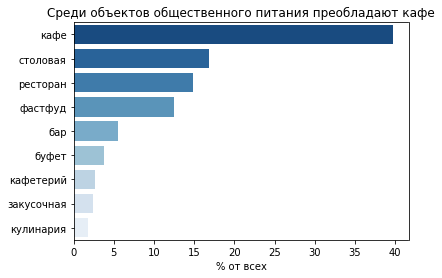

In [17]:
#Виды объектов общественного питания по количеству
sns.barplot(y=df_object['object_type'], x=df_object['%count'], palette='Blues_r')
plt.title('Среди объектов общественного питания преобладают кафе')
plt.xlabel('% от всех')
plt.ylabel('')
plt.show()

Среди объектов общественного питания преобладают кафе, их почти 40% от всех заведений. Второе место занимают столовые, - 17% и рестораны - 15%. На четвертом месте находятся предприятия быстрого обслуживания с 12.5%.
Меньше всего кулинарий, около 2%, а также закусочных и кафетериев - они имеют долю районе 2.5%

### Исследуйте соотношение сетевых и несетевых заведений по количеству. Постройте график.

In [18]:
df_chain=df.groupby('chain')['chain'].agg(['count']).sort_values(by='count', ascending=False)
df_chain['%count']=df_chain['count']/df_chain['count'].sum()*100
df_chain = df_chain.reset_index()
df_chain

,chain,count,%count
0,0,12398,80.68
1,1,2968,19.32


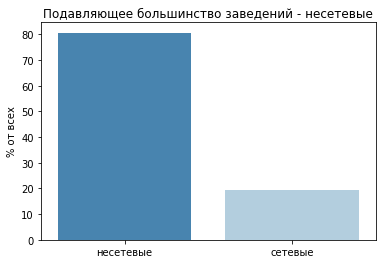

In [19]:
# Соотношение сетевых и несетевых заведений по количеству
sns.barplot(x=['несетевые', 'сетевые'], y=df_chain['%count'], palette='Blues_r')
plt.title('Подавляющее большинство заведений - несетевые')
plt.xlabel('')
plt.ylabel('% от всех')
#plt.grid()
plt.show()

Более 80% всех заведений - несетевые.

### Для какого вида объекта общественного питания характерно сетевое распространение?

In [20]:
df_type_by_chain=df.groupby('object_type')['chain'].agg(['count', 'sum', 'mean']).sort_values(by='mean', ascending=False)
df_type_by_chain['chain_perc']=df_type_by_chain['mean']*100
df_type_by_chain=df_type_by_chain.reset_index()
df_type_by_chain

,object_type,count,sum,mean,chain_perc
0,фастфуд,1923,791,0.41,41.13
1,кулинария,273,78,0.29,28.57
2,ресторан,2285,544,0.24,23.81
3,кафе,6099,1396,0.23,22.89
4,закусочная,360,56,0.16,15.56
5,кафетерий,398,52,0.13,13.07
6,бар,856,37,0.04,4.32
7,буфет,585,11,0.02,1.88
8,столовая,2587,3,0.00,0.12


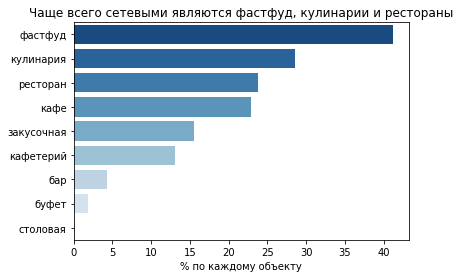

In [21]:
# Объекты общественного питания по сетевому распространению
sns.barplot(y=df_type_by_chain['object_type'], x=df_type_by_chain['chain_perc'], palette='Blues_r')
plt.title('Чаще всего сетевыми являются фастфуд, кулинарии и рестораны')
plt.xlabel('% по каждому объекту')
plt.ylabel('')
#plt.grid()
plt.show()

Сетевое распространение больше всего характерно для предприятий быстрого обслуживания (фастфуд), почти половина из них - сети.
Треть кулинарий, и около четверти всех ресторанов и кафе также сетевые.
Столовые, буфеты и бары практически никогда не сетевые.

### Что характерно для сетевых заведений: много заведений с небольшим числом посадочных мест в каждом или мало заведений с большим количеством посадочных мест?

Посмотрим, в общем, какая ситуация по посадочным местам у сетевых заведений, построив "ящик с усами" и гистограмму.

In [22]:
df[df['chain']==1]['number'].describe()

count   2968.00
mean      52.92
std       57.14
min        0.00
25%       15.00
50%       40.00
75%       72.00
max      580.00
Name: number, dtype: float64

In [23]:
print(np.percentile(df[df['chain']==1]['number'], [95, 99]))

[158.65 275.33]


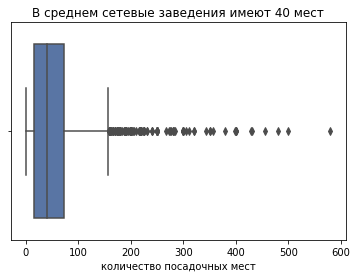

In [24]:
sns.boxplot(x=df[df['chain']==1]['number'])
plt.title('В среднем сетевые заведения имеют 40 мест')
plt.xlabel('количество посадочных мест')
plt.show()    

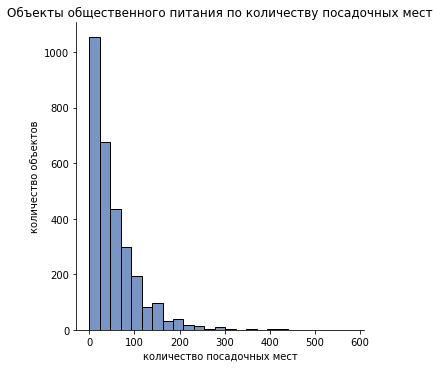

In [25]:
sns.displot(df[df['chain']==1]['number'], bins=25)
plt.title('Объекты общественного питания по количеству посадочных мест')
plt.xlabel('количество посадочных мест')
plt.ylabel('количество объектов')
plt.show()    

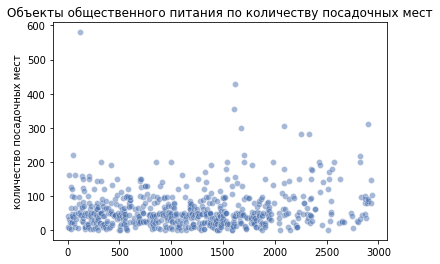

In [26]:
x_values = pd.Series(range(0,len(df[df['chain']==1])))
sns.scatterplot(data=df[df['chain']==1], x=x_values, y=df[df['chain']==1]['number'],alpha=0.5)
plt.title('Объекты общественного питания по количеству посадочных мест')
plt.ylabel('количество посадочных мест')
plt.xlabel('')
plt.show()

Медианное среднее посадочных мест в сетевых заведениях - 40. Т.е. половина всех сетевых объектов общественного питания имеет не более 40 мест. Подавляющее число сетевых заведений, 95-ый процентиль, имеет не более 158 посадочных мест. Оставшиеся 5% заведений представляют собой выбросы, где количество мест достигает максиму в 580. 

Добавим на диаграмму рассеяния информацию о количестве ресторанов в сети.

In [27]:
df_chain=df[df['chain']==1].groupby('object_name')['number'].agg(['count', 'median', 'sum']).sort_values(
    by='count',ascending=False)
df_chain=df_chain.rename(
    columns={'count':'total_rest_chain','median':'median_seats_chain'})

In [28]:
df_chain['perc_rest_all_chain']=df_chain['total_rest_chain']/df_chain['total_rest_chain'].sum()*100

In [29]:
df_new=df.merge(df_chain, on='object_name', how='left')

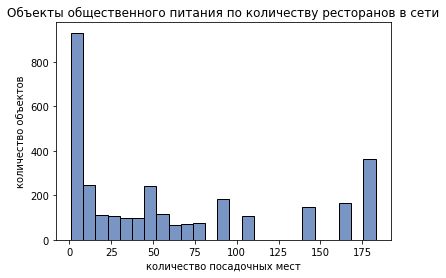

In [30]:
sns.histplot(df_new['total_rest_chain'], bins=25)
plt.title('Объекты общественного питания по количеству ресторанов в сети')
plt.xlabel('количество посадочных мест')
plt.ylabel('количество объектов')
plt.show() 

Заметим, что единичные заведения у нас есть из-за дупликтов, так как некотоые заведения, которые мы не "почистили" (написанные по-другому) оказались "единственными" в сети. Тем не менее, даже принимая это во внимание, мы можем судить о том что большинство сетевых пунктов питания принядлежат сетям, где немного заведений.

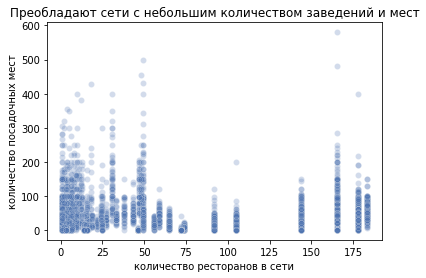

In [31]:
sns.scatterplot(data=df_new[df_new['chain']==1], x='total_rest_chain', y='number',alpha=0.25, legend=False, sizes=(10, 1000))
plt.title('Преобладают сети с небольшим количеством заведений и мест')
plt.ylabel('количество посадочных мест')
plt.xlabel('количество ресторанов в сети')
plt.show()

На диаграмме рассеяния видно, что чаще всего сетевые заведения принадлежат сетям, где немного ресторанов у которых немного посадочных мест (левая нижняя часть графика наиболее густо покрыта точками). Однако, мы наблюдаем небольшую группы сетей с большим количеством ресторанов,часть из которых с реально высоким количеством посадочных мест (правая часть графика). 

### Для каждого вида объекта общественного питания опишите среднее количество посадочных мест. Какой вид предоставляет в среднем самое большое количество посадочных мест? Постройте графики.

In [32]:
df_type=df.groupby('object_type')['number'].agg(['count', 'median']).sort_values(by='median',ascending=False).reset_index()
df_type

,object_type,count,median
0,столовая,2587,103
1,ресторан,2285,80
2,бар,856,35
3,буфет,585,32
4,кафе,6099,30
5,кафетерий,398,6
6,фастфуд,1923,5
7,закусочная,360,0
8,кулинария,273,0


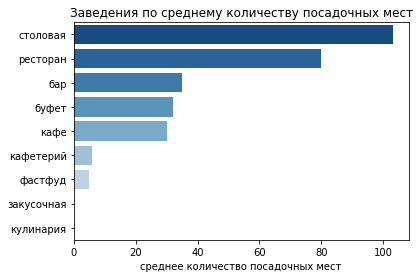

In [33]:
# Заведения по среднему количеству посадочных мест
sns.barplot(x=df_type['median'], y=df_type['object_type'], palette='Blues_r')
plt.title('Заведения по среднему количеству посадочных мест')
plt.xlabel('среднее количество посадочных мест')
plt.ylabel('')
plt.show()

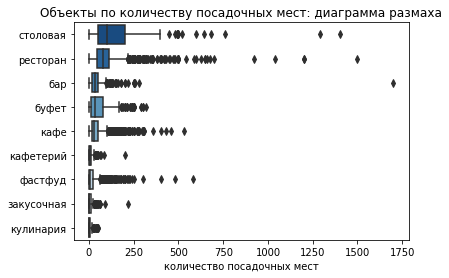

In [34]:
sns.boxplot(x=df['number'], y=df['object_type'], palette='Blues_r', order=df_type['object_type'].unique())
plt.title('Объекты по количеству посадочных мест: диаграмма размаха')
plt.xlabel('количество посадочных мест')
plt.ylabel('')
plt.show()  

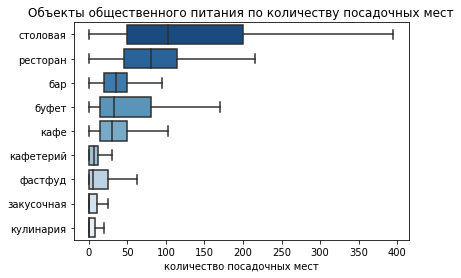

In [35]:
#посттроим тот же график без выбросов
sns.boxplot(x=df['number'], y=df['object_type'], showfliers=False, palette='Blues_r', order=df_type['object_type'].unique())
plt.title('Объекты общественного питания по количеству посадочных мест')
plt.xlabel('количество посадочных мест')
plt.ylabel('')
plt.show()  

Самое большое количество посадочных мест у столовых - около 100, их размеры очень сильно варьируются и могут достигать до 400 мест
Рестораны в среднем имеют  80 мест, их размеры довольно варьируются, но никогда не бывают более 200
У баров, буфетов и кафе в среднем по 30 мест. В барах и кафе почти никогда не бывает больше 100 мест. Буфеты же более неоднородны и могут доходить до 175 мест.
Кулинарии и закусочные как правило вообще не имеют посадочных мест


### Выделите в отдельный столбец информацию об улице из столбца address .


In [36]:
# создадим функцию которая будет выделять из строки с адресом ту часть, где написана улица
def street_only(address):
    street=re.split(', ', address)[1] # регулярное выражение будет создавать список из строки отделенный запятой и пробелом 
    return street # и возвращать второй элемент из этого списка, в котором и содержится информация об улице

In [37]:
df['street']=df['address'] # скопируем столбец с адресом и применим к нему функию
df['street'] = df['street'].apply(street_only)

In [38]:
display(df.sample(10))

,id,object_name,chain,object_type,address,number,street
712,69806,кобзарь,0,кафе,"город Москва, улица Михайлова, дом 29, корпус 3",45,улица Михайлова
9219,162695,макдоналдс,1,фастфуд,"город Москва, Дмитровское шоссе, дом 89",40,Дмитровское шоссе
5619,28025,столовая оао узоры,0,столовая,"город Москва, Полимерная улица, дом 8",42,Полимерная улица
9276,166768,бистро халяль,0,кафе,"город Москва, улица 10-летия Октября, дом 11",36,улица 10-летия Октября
5641,28310,столовая,0,столовая,"город Москва, Окружной проезд, дом 27",290,Окружной проезд
4583,20216,водопад,0,ресторан,"город Москва, улица Юных Ленинцев, дом 71, кор...",214,улица Юных Ленинцев
1837,120267,джоведи,0,ресторан,"город Москва, Озерковская набережная, дом 26",70,Озерковская набережная
4569,29260,столовая 894,0,столовая,"город Москва, Ферганский проезд, дом 10, корпус 4",200,Ферганский проезд
13742,221574,volt coffee,0,кафетерий,"город Москва, Высоковольтный проезд, дом 1, ко...",0,Высоковольтный проезд
10381,175062,шаурмания,0,фастфуд,"город Москва, Мичуринский проспект, дом 38",0,Мичуринский проспект


Заметим, что там, где для "Большой Москвы" адрес указан как "город Москва, поселение, улица" (например, "город Москва, город Зеленоград, корпус 2309А") мы получили название поселения, а не его улицу (т.е. Зеленоград, а не улица в Зеленограде). 

### Постройте график топ-10 улиц по количеству объектов общественного питания. Воспользуйтесь внешней информацией и ответьте на вопрос — в каких районах Москвы находятся эти улицы?

In [39]:
df_street_top=df.groupby('street')['street'].agg(['count']).sort_values(by='count',ascending=False).reset_index()
df_street_top_ten=df_street_top.head(10)
df_street_top_ten

,street,count
0,город Зеленоград,232
1,проспект Мира,204
2,Профсоюзная улица,182
3,Ленинградский проспект,171
4,Пресненская набережная,167
5,Варшавское шоссе,161
6,Ленинский проспект,147
7,поселение Сосенское,138
8,проспект Вернадского,132
9,Кутузовский проспект,114


В наш список попали Зеленоград и Сосенское, вместо улиц у которых были корпуса. Несмторя на то что они формально Москва, мы полагаем, что для целей нашего анализа лучше их исключить, так как это все-таки отдельные поселения, и они не являются улицами. Создадим новый список без них.

In [40]:
df_street_top_ten=df_street_top.query('street != ("город Зеленоград", "поселение Сосенское")').head(10)
df_street_top_ten

,street,count
1,проспект Мира,204
2,Профсоюзная улица,182
3,Ленинградский проспект,171
4,Пресненская набережная,167
5,Варшавское шоссе,161
6,Ленинский проспект,147
8,проспект Вернадского,132
9,Кутузовский проспект,114
10,Каширское шоссе,112
11,Кировоградская улица,110


Теперь у нас есть топ-10 московских улиц, где больше всего заведений общепита. В нем оказались самые протяженные улицы. Лидер - проспект Мира, далее следуют Профсоюзная улица и Ленинградский проспект.

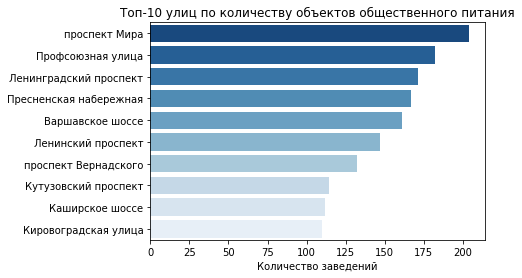

In [41]:
# Объекты общественного питания по среднему количеству посадочных мест
sns.barplot(x=df_street_top_ten['count'],y=df_street_top_ten['street'],palette='Blues_r')
plt.title('Топ-10 улиц по количеству объектов общественного питания')
plt.xlabel('Количество заведений')
plt.ylabel('')
plt.show()

Обратимся к открытым данным мосгаза, чтобы найти к каким район принадлежат данне улицы.

In [42]:
spreadsheet_id = '1TG3CVI5MUV1IpvHtjWGZO3FluTgVXgFUxI1cjyO28r8'
file_name = 'https://docs.google.com/spreadsheets/d/{}/export?format=csv'.format(spreadsheet_id)
r = requests.get(file_name)
mosgas = pd.read_csv(BytesIO(r.content))
mosgas.head()

,streetname,areaid,okrug,area
0,Выставочный переулок,17,ЦАО,Пресненский район
1,улица Гашека,17,ЦАО,Пресненский район
2,Большая Никитская улица,17,ЦАО,Пресненский район
3,Глубокий переулок,17,ЦАО,Пресненский район
4,Большой Гнездниковский переулок,17,ЦАО,Пресненский район


In [43]:
top_areas=df_street_top_ten.merge(mosgas, left_on='street', right_on='streetname')
top_areas=top_areas.drop(columns=['streetname','areaid', 'count'])
top_areas.head()

,street,okrug,area
0,проспект Мира,СВАО,Алексеевский район
1,проспект Мира,СВАО,Ярославский Район
2,проспект Мира,СВАО,Район Марьина роща
3,проспект Мира,СВАО,Останкинский район
4,проспект Мира,СВАО,Район Ростокино


Так как топопвые улицы - очень протяженные, они проходят через множество районов. Сгруппируем список по районам, чтобы посмотреть какие из них повторяются, и таким образом, через которые проходит более одной топовой улицы.

In [44]:
top_areas.groupby('area')['area'].agg(['count']).sort_values(by='count',ascending=False).head(20)

,count
area,
Район Чертаново Центральное,2
Донской район,2
Ломоносовский район,2
Район Проспект Вернадского,2
Обручевский район,2
Район Теплый Стан,2
Район Нагатино-Садовники,2
Район Чертаново Южное,2
Район Тропарево-Никулино,2


У нас получился список, где есть из 9 районов, где проходят 2 улицы по с наибольшим количеством общепита. Посмотрим теперь на округа, в которых находятся топовые улицы.

In [45]:
top_okrug=top_areas.groupby('okrug')['okrug'].agg(['count'])
top_okrug.sort_values(by='count',ascending=False)

,count
okrug,
ЮАО,14
ЮЗАО,14
ЗАО,7
СВАО,6
САО,4
ЦАО,3


Мы видим, что топовые улицы в большинстве своем находятся на юге, юго-западе и западе Москвы. Далее идет Северо-Восток и Север, и замыкает список Центральный округ. Конечно, в центре улице в основном не такие длинные, чтобы попасть в список топовых улиц по количеству точек общепита. Вывод, который мы можем сделать для нашего бизнеса - возможно, чтоит осваивать округа, где меньше точек общепита, дальше от топовых улиц. Можно обратить внимание на восток и север Москвы, возможно, там рынок менее насыщен.

Однако, полезно посмотреть ситуацию в целом по заведениям в районах Москвы. 

In [46]:
areas=df.merge(mosgas, left_on='street', right_on='streetname')
areas_area=areas.groupby(['area', 'okrug'])['area'].agg(['count']).sort_values(by='count',ascending=False)
areas_area['perc']=areas_area['count']/areas_area['count'].sum()*100
areas_area=areas_area.reset_index()
areas_area=areas_area.rename(columns={'area':'раойон', 'okrug':'округ','count':'объектов', 'perc':'доля'})

Посмотрим на топ-10 районов по количеству заведений

In [47]:
areas_top=areas_area.head(10)
with pd.option_context('display.precision', 2):
    areas_top=areas_top.style.background_gradient(cmap = 'Blues')
areas_top

,раойон,округ,объектов,доля
0,Тверской район,ЦАО,1127,3.8
1,Пресненский район,ЦАО,788,2.7
2,Басманный район,ЦАО,702,2.4
3,Мещанский район,ЦАО,668,2.3
4,Даниловский район,ЮАО,667,2.3
5,Донской район,ЮАО,581,2
6,Таганский район,ЦАО,528,1.8
7,Обручевский район,ЮЗАО,492,1.7
8,Район Замоскворечье,ЦАО,479,1.6
9,Район Гагаринский,ЮЗАО,474,1.6


Посмотрим на хвост этого списка, т.е. районы, где меньше всего заведений.

In [48]:
areas_tail=areas_area.tail(10)
with pd.option_context('display.precision', 2):
    areas_tail=areas_tail.style.background_gradient(cmap = 'Blues')
areas_tail

,раойон,округ,объектов,доля
113,Район Марфино,СВАО,60,0.2
114,Район Косино-Ухтомский,ВАО,59,0.2
115,Район Южное Медведково,СВАО,58,0.2
116,Район Бирюлево Западное,ЮАО,58,0.2
117,Район Братеево,ЮАО,41,0.14
118,Район Куркино,СЗАО,40,0.14
119,Район Новокосино,ВАО,37,0.13
120,Район Капотня,ЮВАО,27,0.091
121,Район Некрасовка,ЮВАО,8,0.027
122,Район Восточный,ВАО,4,0.014


In [49]:
okrugs=areas.groupby('okrug')['okrug'].agg(['count']).sort_values(by='count',ascending=False)
okrugs['perc']=okrugs['count']/okrugs['count'].sum()*100
okrugs=okrugs.reset_index().head(10)
okrugs=okrugs.rename(columns={'okrug':'округ','count':'объектов', 'perc':'доля'})

In [50]:
with pd.option_context('display.precision', 2):
    okrugs=okrugs.style.background_gradient(cmap = 'Blues')
okrugs

,округ,объектов,доля
0,ЦАО,5824,20
1,ЮАО,4417,15
2,ЮЗАО,4032,14
3,САО,3436,12
4,СВАО,3281,11
5,ЗАО,2542,8.6
6,ВАО,2128,7.2
7,ЮВАО,1929,6.5
8,Зеленоград,1001,3.4
9,СЗАО,998,3.4


Данные по всем точкам общепита показывают, что больше всего заведений в Тверском районе и нескольких других районах Центрального округа, далее идут районы из Юга и Юго-Запада. Те же лидеры в общем зачете точек по округам. На последнем месте по районам - Некрасовка и Восточный, по районам - Северо-Запад. Таким образом, в общем на Востоке, Юго-Востоке и Северо-Западе Москвы заведений меньше.

### Найдите число улиц с одним объектом общественного питания. Воспользуйтесь внешней информацией и ответьте на вопрос — в каких районах Москвы находятся эти улицы?

In [51]:
df_street_tail=df_street_top[df_street_top['count']==1]

In [52]:
print('число улиц с одним объектом общественного питания:', df_street_tail['street'].count())

число улиц с одним объектом общественного питания: 579


In [53]:
tail_areas=df_street_tail.merge(mosgas, left_on='street', right_on='streetname')
tail_areas=tail_areas.drop(columns=['streetname','areaid', 'count'])
tail_areas.tail(10)

,street,okrug,area
550,Дмитровский переулок,ЦАО,Тверской район
551,Дивизионная улица,ЗАО,Район Внуково
552,Яхромская улица,САО,Дмитровский район
553,Жигулёвская улица,ЮВАО,Район Кузьминки
554,Живарев переулок,ЦАО,Красносельский район
555,Есенинский бульвар,ЮВАО,Район Кузьминки
556,Елоховский проезд,ЦАО,Басманный район
557,Егорьевский проезд,ЮВАО,Район Люблино
558,Докучаев переулок,ЦАО,Красносельский район
559,Гвардейская улица,ЗАО,Можайский Район


In [54]:
tail_areas.groupby(['area', 'okrug'])['area'].agg(['count']).sort_values(by='count',ascending=False).head(10)

,,count
area,okrug,
Таганский район,ЦАО,27
Район Хамовники,ЦАО,26
Басманный район,ЦАО,25
Тверской район,ЦАО,20
Пресненский район,ЦАО,19
Район Марьина роща,СВАО,18
Район Арбат,ЦАО,17
Мещанский район,ЦАО,16
Район Сокольники,ВАО,15


In [55]:
tail_okrug=tail_areas.groupby('okrug')['okrug'].agg(['count'])
tail_okrug.sort_values(by='count',ascending=False)

,count
okrug,
ЦАО,185
ВАО,72
СВАО,67
САО,55
ЮВАО,55
ЗАО,41
ЮАО,30
СЗАО,27
ЮЗАО,27


По нашим данным число улиц с одним объектом общественного питания - 579. В Таганском районе, Хамовниках и Басманном больше всего улиц с одним заведением, они находится в центре и там много коротких улиц и переулков. В списке в основном центральные районы, но есть Марьина роща и Сокольники с Северо-Востока и Востока. Там дело скорее всего в малом количестве заведений.

### Посмотрите на распределение количества посадочных мест для улиц с большим количеством объектов общественного питания. Какие закономерности можно выявить?

In [56]:
df_top_streets_seats=df.query('street in @df_street_top_ten.street')

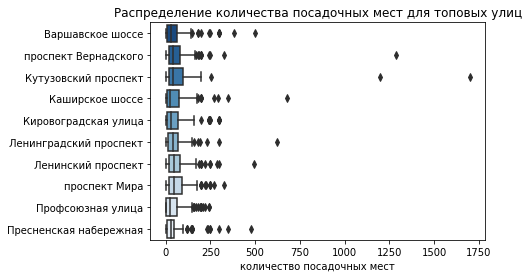

In [57]:
sns.boxplot(x=df_top_streets_seats['number'], y=df_top_streets_seats['street'], palette='Blues_r')
plt.title('Распределение количества посадочных мест для топовых улиц')
plt.xlabel('количество посадочных мест')
plt.ylabel('')
plt.show()  

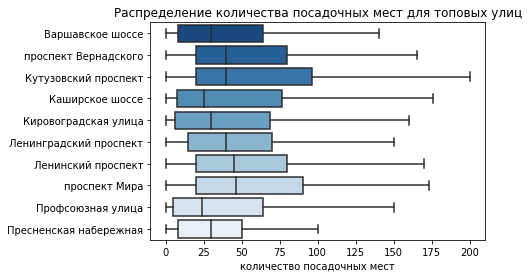

In [58]:
sns.boxplot(x=df_top_streets_seats['number'], y=df_top_streets_seats['street'], palette='Blues_r',showfliers=False)
plt.title('Распределение количества посадочных мест для топовых улиц')
plt.xlabel('количество посадочных мест')
plt.ylabel('')
plt.show()  

Распределение количества посадочных мест для улиц с большим количеством объектов показывает, что подавляющее число заведений на этих улицах имеют до 100 мест (есть, конечно, и редкие исключения), а в среднем (медианном) имеют по 25-40 мест. ТО есть большинство заведений на топ-улицах - не слишком большие.

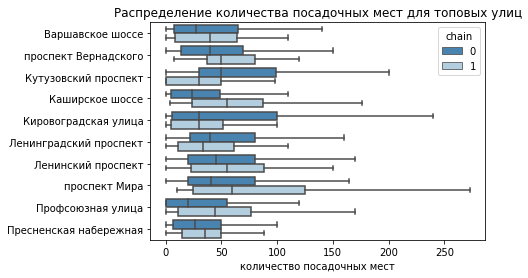

In [59]:
#plt.figure(figsize=(10,8))
sns.boxplot(x=df_top_streets_seats['number'], y=df_top_streets_seats['street'],showfliers=False,  palette='Blues_r', hue=df_top_streets_seats['chain'])
plt.title('Распределение количества посадочных мест для топовых улиц')
plt.xlabel('количество посадочных мест')
plt.ylabel('')
plt.show()  

Как правило, несетевые заведения имеют больше посадочных мест на этих улицах, однако есть несколько улиц, в которых у сетевых заведений число мест больше - это Каширское шоссе, проспект Мира и Профсоюзная.

Построим диаграмму распределения числа посадочных мест для топовых улиц, чтобы попробовать обнаружить и другие закономерности. Добавим параметр типа заведения, обозначив его цветом, а также подчернем вместимость заведения размером точки.

In [60]:
df_top_streets_seats=df_top_streets_seats[df_top_streets_seats['number']<250]

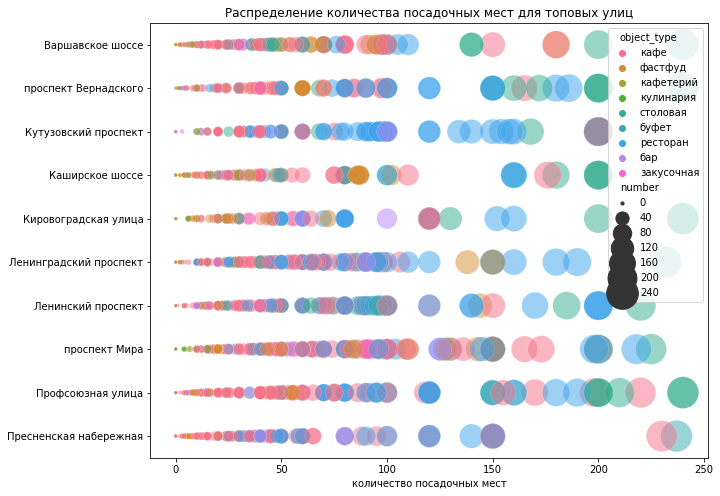

In [61]:
plt.figure(figsize=(10,8))
sns.scatterplot(data=df_top_streets_seats, x=df_top_streets_seats['number'], y=df_top_streets_seats['street'],alpha=0.5, hue="object_type", size=df_top_streets_seats['number'], sizes=(10, 1000))
plt.title('Распределение количества посадочных мест для топовых улиц')
plt.ylabel('')
plt.xlabel('количество посадочных мест')
plt.show()

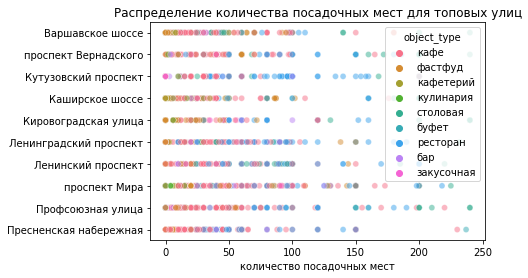

In [62]:
#plt.figure(figsize=(10,8))
sns.scatterplot(data=df_top_streets_seats, x=df_top_streets_seats['number'], y=df_top_streets_seats['street'],alpha=0.5, hue="object_type")
plt.title('Распределение количества посадочных мест для топовых улиц')
plt.ylabel('')
plt.xlabel('количество посадочных мест')
plt.show()

Несмотря на то, что график получился довольно пестрый, можно заметить, что заведения с высоким числом посадочных мест на всех топовых улицах - это, как правило, столовые и рестораны. Кафе чаще всего имеют меньше 50 мест.

## Сделайте общий вывод и дайте рекомендации о виде заведения, количестве посадочных мест, а также районе расположения. Прокомментируйте возможность развития сети.

Подведем итоги.
Виды объектов по количеству:
- Среди объектов общественного питания преобладают кафе, столовые и рестораны. 
- Меньше всего кулинарий, закусочных и кафетериев.

Объекты общественного питания по сетевому распространению:
- 80% всех заведений - несетевые
- Сетевое распространение больше всего характерно для предприятий быстрого обслуживания (фастфуд), почти половина из них - сети
- Треть кулинарий, и около четверти всех ресторанов и кафе также сетевые
- Столовые, буфеты и бары практически никогда не сетевые

Характеристики сетевых заведений: посадочные места и число заведений: 
- Половина всех сетевых объектов общественного питания имеет не более 40 мест. 
- Подавляющее число сетевых заведений (95%), имеет не более 158 посадочных мест. 
- Как правило в сети немного заведений с небольшим количеством посадочных мест
- Есть крупные игроки - сети с очень большим количеством ресторанов, часть которых имеют реально  большую вместимость

Объекты общественного питания по среднему количеству посадочных мест:
- Самое большое количество посадочных мест у столовых - около 100, их размеры очень сильно варьируются и могут достигать до 400 мест
- Рестораны в среднем имеют  80 мест, их размеры довольно варьируются, но никогда не бывают более 200
- У баров, буфетов и кафе в среднем по 30 мест. В барах и кафе почти никогда не бывает больше 100 мест. Буфеты же более неоднородны и могут доходить до 175 мест.
- Кулинарии и закусочные как правило вообще не имеют посадочных мест

Улицы и районы по количеству объектов общественного питания:
- Топовые улицы в большинстве своем находятся на юге, юго-западе и западе. Это очень длинные улицы идущие через несколько районов
- Большинство топовых районов находятся в Центре , остальные на Юге и Юго-Западе. 
- На Востоке, Юго-Востоке и Северо-Западе Москвы заведений меньше всего
- В центре больше всего улиц с одним заведением

Распределение количества посадочных мест для топовых улиц: 
- Подавляющее число заведений имеют до 100 мест 
- В среднем заведения небольшие, по 25-40 мест. 
- Как правило, несетевые заведения имеют больше посадочных мест 
- заведения с высоким числом посадочных мест - столовые и рестораны. 
- Кафе чаще всего имеют меньше 50 мест.

Рекомендации:
- Стоит начать с несетевого заведения и в будущем задуматься о небольшой сети 
- Наиболее подходящий тип заведения кафе или ресторан
- Рекомендуемое количество посадочных мест - 40-80
- Расположение На Востоке, Юго-Востоке и Северо-Западе Москвы - там на данный момент меньше всего заведений

### Шаг №3. Подготовка презентации
Подготовьте презентацию исследования для инвесторов. Для создания презентации используйте любой удобный инструмент, но отправить презентацию нужно обязательно в формате pdf. Приложите ссылку на презентацию в markdown-ячейке в формате:
Презентация: <ссылка на облачное хранилище с презентацией> 

Презентация: <https://drive.google.com/file/d/1bpPC1qC2Gjc_GBNwuN2sxWOTE542aDGV/view?usp=sharing> 